# AI‑Driven Data Mining Framework for Assessing Decision‑Tree Rule Hiding in Regulated Data


This notebook serves as both a methodological record and analytical report for a large‑scale study into **decision‑tree rule hiding** under modern privacy regulations.  The goal is to characterise the background landscape of decision‑tree applications in industry, identify the types of data features being used, and determine which of those features fall within the scope of privacy laws.  The rationale is that understanding the prevalence and regulatory status of these features informs why methods for hiding or obfuscating decision‑tree rules are becoming increasingly important.

### Methodological overview

1. **Data source selection:** Published scientific articles were chosen as the primary source of real‑world examples because peer‑reviewed publications often describe the use of analytics methods in practice.  A bespoke Python package was developed to mine publicly available article metadata from the Crossref and OpenAlex APIs.  Searches were constructed for twelve industries—  

    *Banking Finance, Healthcare Pharma, Insurance, E‑commerce Retail, Telecom Network Security, Social Media, Education Learning Analytics, IoT Smart Systems, Government Public Administration, Cybersecurity Intrusion Detection, HR Recruitment* and *Transportation Logistics*   
   
    —to capture the breadth of decision‑tree applications.

2. **Article retrieval and merging:** For each industry‑specific query, 1 000 results were retrieved from each source (Crossref and OpenAlex).  The results were merged and deduplicated based on DOIs to create a consolidated corpus of candidate articles.

3. **Relevance filtering with AI:** Because search results can be noisy, a language model was prompted to classify each article as **relevant** or **not relevant** to the application of decision trees using its title, abstract and publication venue.  Only articles flagged as relevant were retained.

4. **Domain validation:** The same AI model was then used to assign each relevant article to one of the twelve target industries (or to *none of the above*), producing a validated domain label for each record.

5. **Feature extraction and validation:** A key objective is to understand which data features are used in decision‑tree models.  The AI was instructed to extract from each abstract any feature names mentioned in connection with training a decision tree.  A second validation step confirmed that each extracted feature was indeed used for model training and not merely mentioned in passing.

6. **Attribute‑class assignment:** Each validated feature was mapped by the AI to one of thirteen privacy‑aware ***attribute classes***:   
    *Identifier_PII*, *Contact_Info*, *Device_OnlineID*, *Biometric*, *Location_IoT*, *Health_Clinical*, *Financial*, *Child_Data*, *Demographic*, *Behavioural*, *Environmental*, *Operational_Business* or *Other*.  
   
    These classes align with common privacy taxonomies and are used in later regulatory matching.

7. **Regulatory text mining:** Official texts of major privacy laws (e.g., GDPR, HIPAA, CCPA) were downloaded.  The AI was instructed to identify passages and paragraphs that mention, regulate or otherwise pertain to any of the thirteen attribute classes listed above.  This produced a mapping from attribute classes to regulatory excerpts.

8. **Regulation–feature linking:** By cross‑referencing the attribute class of each feature with the regulatory passages collected, we created a feature–regulation table.  For each feature, the AI assessed whether it is **regulated** or **not regulated** under the relevant law and assigned a confidence level (high, medium or low).  This step recognises that legal interpretation can be ambiguous; the confidence score captures the strength of the AI’s assessment.

9. **Final dataset and analysis scope:** Merge and harmonise the validated features with the regulation‑mapping tables, deduplicate records and align each feature with its attribute class and regulation status. From this point onward, unless explicitly stated otherwise, **the analytic corpus is limited to those features that the AI assessed as *Regulated* with *High* confidence**. In other words, we analyse only high‑confidence regulated features; items with Medium or Low confidence are omitted from the main analyses and appear only in sensitivity checks.

## Regulatory Information for Context

The dataset does not contain the enactment years of the regulations. The following table lists the official regulations and the enactment years, sourced from authoritative references (citations indicated for validation):

| Regulation | Enactment year | Source |
|-----------|---------------|-------|
| HIPAA | 1996 | Signed into law on 21 August 1996【617437092921950†L114-L116】 |
| HITECH | 2009 | Signed into law on 17 February 2009【316138370182581†L209-L216】 |
| CCPA | 2018 | Passed in 2018【89971892187549†L199-L201】 |
| CPRA | 2020 | Approved by voters on 3 November 2020【943854279962298†L89-L96】 |
| GDPR | 2018 | Became enforceable on 25 May 2018【973256186925503†L21-L31】 |
| ePrivacy Directive | 2002 | Adopted in 2002 and amended in 2009【765434439357368†L114-L119】 |
| NIS2 | 2023 | Entered into force in January 2023【6750382137667†L125-L127】 |
| PSD2 | 2016 | Applied from 12 January 2016【724292858980272†L195-L197】 |
| EU eHealth Network | 2011 | Established under Directive 2011/24/EU【222916198544407†L72-L75】 |
| GLBA | 1999 | Signed into law in November 1999【329363762707909†L43-L46】 |
| COPPA | 1998 | Signed into law on 21 October 1998【227641286164990†L415-L421】 |
| FERPA | 1974 | Enacted in 1974. |
| ECPA | 1986 | Enacted in 1986. |


In [2]:
import os
os.getcwd()
os.chdir("/Users/vesk/sitecore.co.ai.assistant.MONE-51951-upadate_manifest_repo_lookup")

In [3]:
import pandas as pd
import json
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency, linregress

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

with zipfile.ZipFile('data/processed/validated_feature_regulation_regulated.json.zip') as z:
    reg_data = json.loads(z.read('validated_feature_regulation_regulated.json'))
reg_df = pd.DataFrame(reg_data)
reg_df['doi_clean'] = reg_df['doi'].str.lower().str.replace('https://doi.org/','', regex=False).str.replace('http://doi.org/','', regex=False).str.strip()

features_df = pd.read_csv('data/processed/validated_features.csv')
features_df['doi_clean'] = features_df['doi'].str.lower().str.replace('https://doi.org/','', regex=False).str.replace('http://doi.org/','', regex=False).str.strip()

merged_df = reg_df.merge(features_df[['doi_clean','year','domain','features']], on='doi_clean', how='left')
merged_df['year_int'] = merged_df['year'].dropna().astype(int)

# Dictionary of release years
release_years = {
    'HIPAA': 1996, 
    'HITECH': 2009, 
    'CCPA': 2018, 
    'CPRA': 2020, 
    'GDPR': 2018,
    'ePrivacy Directive': 2002,
    'NIS2': 2023, 
    'PSD2': 2016, 
    'EU eHealth Network': 2011,
    'GLBA': 1999,
    'COPPA': 1998, 
    'FERPA': 1974,
    'ECPA': 1986
}

ENACT_YEARS = release_years
enact_years = release_years

## Descriptive statistics

This section reports high-level properties of the analytic corpus **restricted to records validated with High confidence**. It does **not** repeat per-regulation counts (those are shown in Figures 1–2).

- Articles (unique DOIs) used in analysis
- Publication year range
- Regulated feature instances (feature–regulation pairings)
- Distinct regulated features
- Number of industry domains represented
- Number of attribute classes represented


In [4]:
md = merged_df[merged_df['confidence'] == 'High'].copy()
md['year_int'] = md['year_int'].clip(upper=2025)

summary = {
    "Articles (unique DOIs)": md['doi_clean'].nunique(),
    "Year range (min–max)": f"{int(md['year_int'].min())}–{int(md['year_int'].max())}",
    "Regulated feature instances (feature–regulation pairs)": len(md),
    "Distinct regulated features": md['feature_clean'].nunique(),
    "Industry domains represented": md['domain'].nunique(),
    "Attribute classes represented": md['attribute_class'].nunique(),
}

import pandas as pd
display(pd.DataFrame(summary, index=["Value"]).T)


,Value
Articles (unique DOIs),850
Year range (min–max),1987–2025
Regulated feature instances (feature–regulation pairs),4377
Distinct regulated features,1264
Industry domains represented,12
Attribute classes represented,11


### Figure 1: Regulated feature instances per regulation

Counts of **feature–regulation pairings** in the High-confidence corpus. A higher bar indicates more mentions/usages of regulated features associated with that regulation across the corpus.


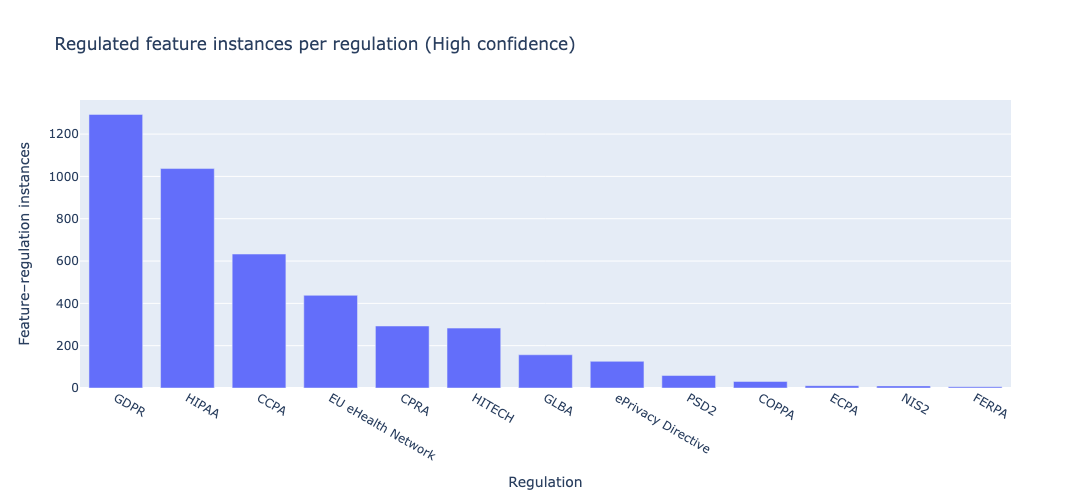

In [5]:
import plotly.express as px

f1 = merged_df[merged_df['confidence'] == 'High'].copy()
f1['year_int'] = f1['year_int'].clip(upper=2025)

per_reg_instances = (
    f1.groupby('reg_id')
      .size()
      .reset_index(name='instances')
      .sort_values('instances', ascending=False)
)

fig1 = px.bar(
    per_reg_instances,
    x='reg_id', y='instances',
    title='Regulated feature instances per regulation (High confidence)',
    labels={'reg_id':'Regulation','instances':'Feature–regulation instances'},
)
fig1.update_layout(xaxis={'categoryorder':'total descending'}, bargap=0.25, height=500)
fig1.show()


**Interpretation:** Figure 1 shows the number of regulated feature **instances** per regulation among high‑confidence records. Regulations such as **HIPAA** and **GDPR** dominate, indicating they govern a large share of the features in the corpus. Newer laws like **NIS2** have fewer entries because of their recent enactment, while sector‑specific statutes such as **FERPA** and **COPPA** cover narrower domains.


### Figure 2: Distinct regulated features per regulation

Counts of **unique features** governed by each regulation in the High-confidence corpus.



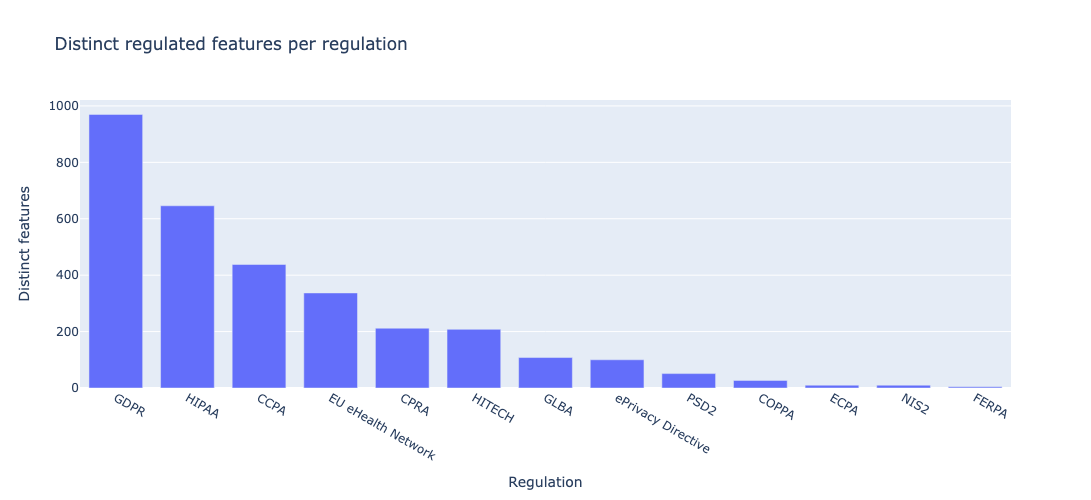

In [6]:
import plotly.express as px

f2 = merged_df[merged_df['confidence'] == 'High'].copy()
f2['year_int'] = f2['year_int'].clip(upper=2025)

per_reg_unique = (
    f2.groupby('reg_id')['feature_clean']
      .nunique()
      .reset_index(name='distinct_features')
      .sort_values('distinct_features', ascending=False)
)

fig2 = px.bar(
    per_reg_unique,
    x='reg_id', y='distinct_features',
    title='Distinct regulated features per regulation',
    labels={'reg_id':'Regulation','distinct_features':'Distinct features'},
)
fig2.update_layout(xaxis={'categoryorder':'total descending'}, bargap=0.25, height=500)
fig2.show()

**Interpretation:** Figure 2 reports the number of **distinct regulated features** per regulation. The pattern mirrors Figure 1, with **HIPAA** and **GDPR** exhibiting the broadest coverage of unique features. This suggests that these frameworks mandate disclosure across a wide variety of data types, whereas regulations like **ECPA** or **COPPA** apply to more limited feature sets.

### Figure 3: Domain Distribution

This pie chart illustrates the distribution of records across the top domains in the dataset.


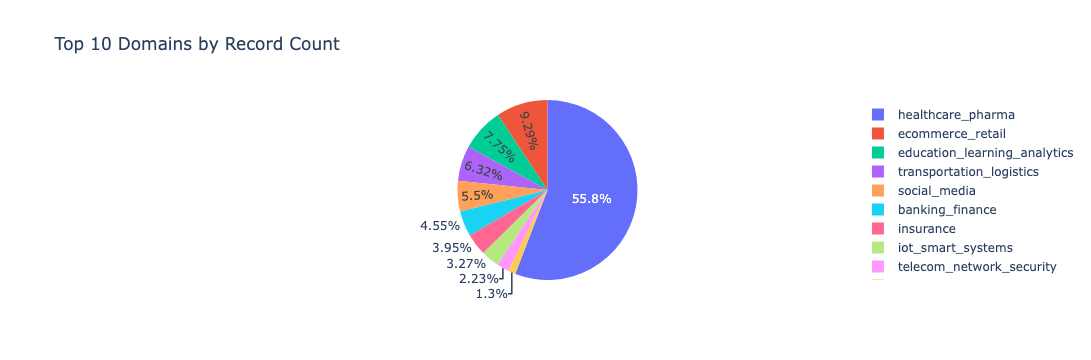

In [7]:
domain_counts = merged_df['domain'].value_counts()
top_domains = domain_counts.head(10)
fig = px.pie(values=top_domains.values, names=top_domains.index, title='Top 10 Domains by Record Count')
fig.show()

**Interpretation:** Figure 3 summarises the distribution of **domains** across all regulated features. The **healthcare and pharmaceutical** sector overwhelmingly dominates, accounting for more than half of the records. E‑commerce/retail, education, transportation and social-media domains each contribute a much smaller but still noticeable share. Financial services, insurance and other sectors appear only at a few percent, showing that the dataset is heavily skewed toward health-related use cases.


### Figure 4: Attribute Class Distribution

This bar chart summarises the number of regulated feature records falling into each attribute class. It provides a sense of which data categories are most commonly governed under the analysed regulations.


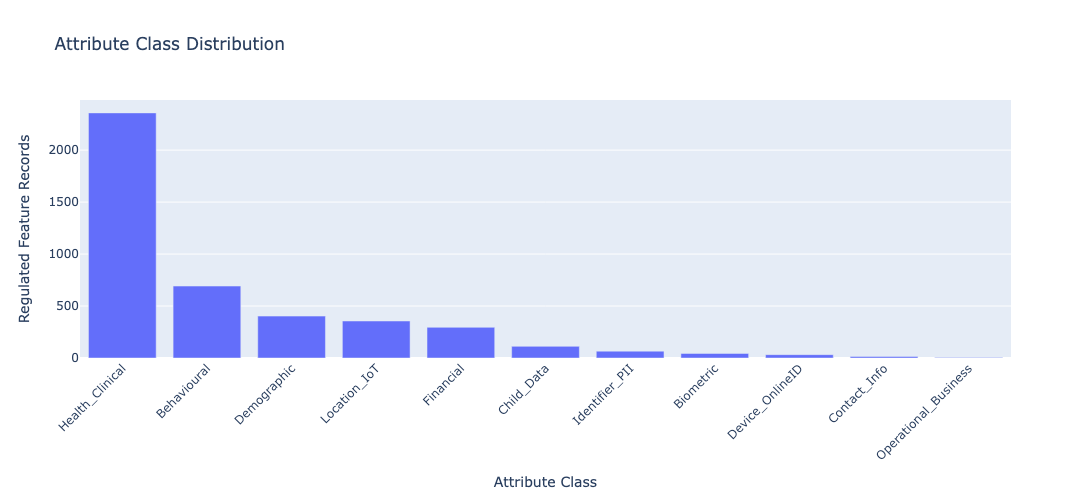

In [8]:
attr_counts = merged_df['attribute_class'].value_counts().reset_index()
attr_counts.columns = ['Attribute Class', 'feature_records']

fig = px.bar(attr_counts, x='Attribute Class', y='feature_records',
             title='Attribute Class Distribution',
             labels={'feature_records':'Regulated Feature Records','Attribute Class':'Attribute Class'},
             color_discrete_sequence=['#636EFA'])
fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()


**Interpretation:** Figure 4 displays the distribution of **attribute classes**. **Health Clinical** attributes make up by far the largest share, reflecting the dominance of healthcare-focused records. **Behavioural** and **Demographic** attributes form the next largest groups, while categories like **Location/IoT** and **Financial** are of moderate size. Identity-, contact‑related and operational attributes appear less frequently, indicating a narrower (less clear or not direct) coverage.

### Figure 5: Domain × regulation matrix — distinct regulated features

Each cell reports the **number of distinct features**  that are **validated as Regulated with High confidence** for the corresponding **industry domain** × **regulation** pair.  
Rows (domains) and columns (regulations) are **ordered by their total distinct-feature counts** to make concentration patterns visible.



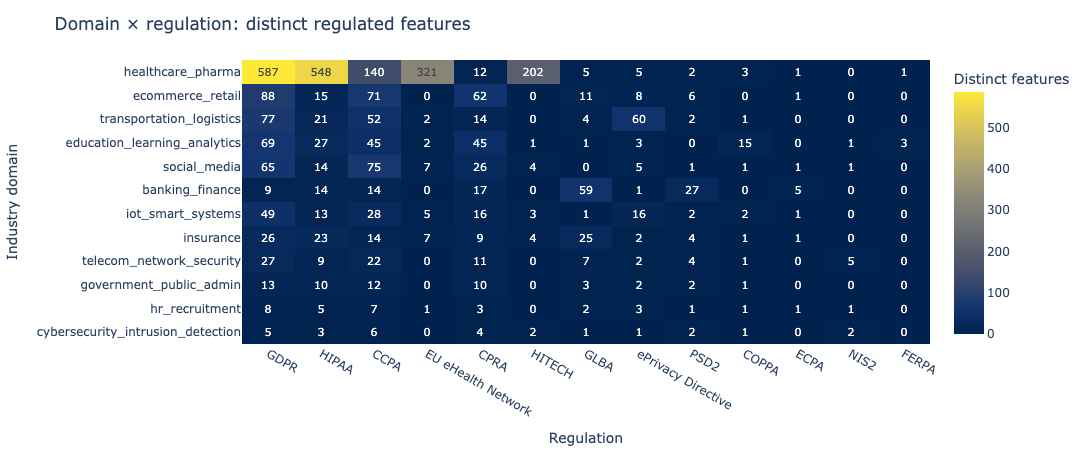

In [9]:
import plotly.express as px

df5 = merged_df.loc[merged_df['confidence'] == 'High'].copy()

mat = (df5.groupby(['domain', 'reg_id'])['feature_clean']
          .nunique()
          .reset_index(name='distinct_features'))

pivot = (mat.pivot(index='domain', columns='reg_id', values='distinct_features')
            .fillna(0)
            .astype(int))

pivot = pivot.loc[pivot.sum(axis=1) > 0, pivot.sum(axis=0) > 0]

row_order = pivot.sum(axis=1).sort_values(ascending=False).index
col_order = pivot.sum(axis=0).sort_values(ascending=False).index
pivot = pivot.loc[row_order, col_order]

height = max(400, 120 + 28 * len(pivot))
fig5 = px.imshow(
    pivot,
    color_continuous_scale="Cividis",
    text_auto=True,
    aspect="auto",
    labels=dict(color="Distinct features")
)
fig5.update_layout(
    title="Domain × regulation: distinct regulated features",
    xaxis_title="Regulation",
    yaxis_title="Industry domain",
    coloraxis_colorbar=dict(title="Distinct features"),
    width=None,
    height=height,
    margin=dict(l=80, r=40, t=60, b=60)
)

# Improve text legibility on light cells
fig5.update_traces(textfont=dict(size=11))
fig5.show()



**Interpretation:** Figure 5 presents a heatmap of **distinct regulated features** across domain–regulation pairs. It highlights strong concentrations of features where domain and regulation align: **HIPAA** features cluster in the **Health** domain, **GLBA** features in **Financial**, and **GDPR** spans multiple domains. Sparse cells reveal domains that certain regulations do not address.

### Figure 6: Distinct regulated features per year by regulation

Time series of **distinct features** per **regulation** and **year** within the High-confidence corpus.  
Vertical dashed lines mark regulation **enactment years** (*External input; annotation only*).



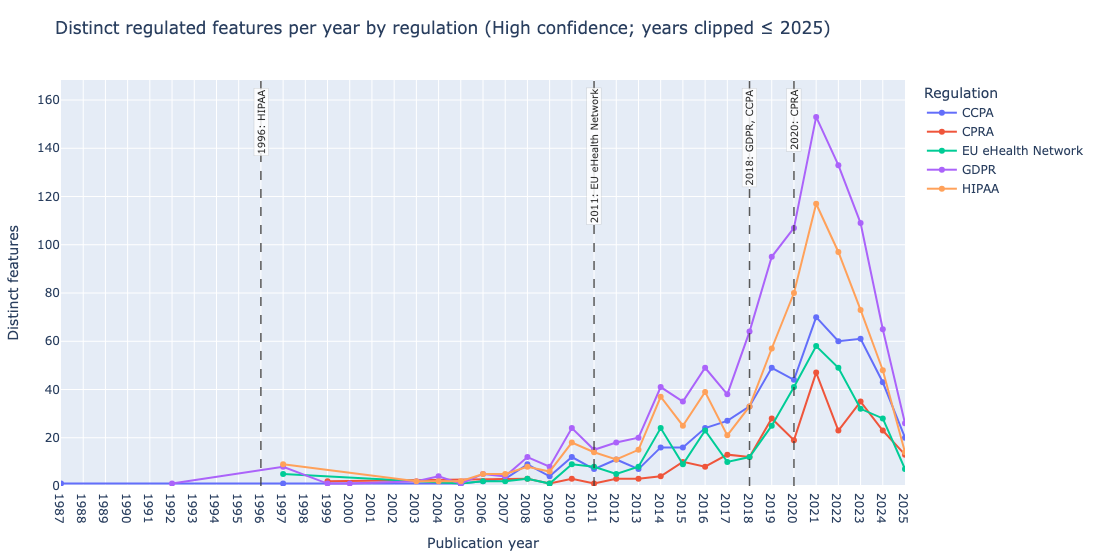

In [10]:
f6 = merged_df.loc[merged_df['confidence'] == 'High'].copy()
f6['year_int'] = f6['year_int'].clip(upper=2025)

per_year = (
    f6.groupby(['reg_id', 'year_int'])['feature_clean']
      .nunique()
      .reset_index(name='distinct_features')
)

top_regs = (
    f6.groupby('reg_id')['feature_clean']
      .nunique()
      .sort_values(ascending=False)
      .head(5)
      .index
)
per_year_top = per_year[per_year['reg_id'].isin(top_regs)].copy()
if per_year_top.empty:
    raise ValueError("No data for Figure 6 after filtering to High confidence and top regulations.")

fig6 = px.line(
    per_year_top.sort_values(['reg_id','year_int']),
    x='year_int',
    y='distinct_features',
    color='reg_id',
    markers=True,
    title='Distinct regulated features per year by regulation (High confidence; years clipped ≤ 2025)',
    labels={'year_int':'Publication year','distinct_features':'Distinct features','reg_id':'Regulation'}
)

xmin = int(per_year_top['year_int'].min())
fig6.update_xaxes(range=[xmin, 2025], tickmode='linear', dtick=1)
ymax = max(1, int(per_year_top['distinct_features'].max()))
fig6.update_yaxes(range=[0, ymax * 1.10])

fig6.update_layout(
    height=560,
    margin=dict(l=60, r=40, t=80, b=60),
    legend_title_text='Regulation',
    title={'y': 0.96}
)

_ENACT = globals().get('ENACT_YEARS', globals().get('enact_years', None))
if _ENACT is None:
    raise NameError("ENACT_YEARS (or enact_years) must be defined earlier (see External inputs cell).")

year_to_regs = {}
for reg in top_regs:
    yr = _ENACT.get(reg)
    if yr is None:
        continue
    yr = min(yr, 2025)
    year_to_regs.setdefault(yr, []).append(reg)

for yr in sorted(year_to_regs):
    fig6.add_vline(
        x=yr,
        line_dash='dash',
        line_color='rgba(60,60,60,0.85)',
        line_width=1.5
    )

    regs_label = ", ".join(year_to_regs[yr])
    fig6.add_annotation(
        x=yr,
        y=0.98,
        xref='x',
        yref='paper',
        text=f"{yr}: {regs_label}",
        showarrow=False,
        textangle=-90,
        font=dict(size=10, color='rgba(40,40,40,0.95)'),
        xanchor='center',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.85)',
        bordercolor='rgba(120,120,120,0.3)',
        borderwidth=0.5
    )

fig6.show()


**Interpretation:** Figure 6 plots the number of **distinct features** contributed each year by regulation. Many regulations show a burst of activity around their enactment year followed by slower growth. For example, the Californian laws **CCPA** (2018) and **CPRA** (2020) show sharp rises in the late 2010s and early 2020s. Longstanding laws like **HIPAA** (1996), **FERPA** (1974) and **ECPA** (1986) accumulate features steadily but exhibit little change after the early 2000s.


### Figure 7: Domain share over time

Stacked area chart showing, for each publication year, the **proportion** of **distinct regulated features** attributed to each **industry domain** within the High-confidence corpus.  
Vertical dashed lines mark regulation **enactment years**.

**Interpretation:** Figure 7 shows how the share of distinct regulated features across domains evolves over time. Early years are dominated almost exclusively by the healthcare/pharma domain. Starting around the mid‑2010s, other sectors — such as transportation/logistics, e‑commerce/retail, education and social media — begin to gain prominence. By the early 2020s, transportation/logistics becomes one of the largest contributors, while healthcare remains significant but less dominant, indicating diversification of regulated data sources over time.

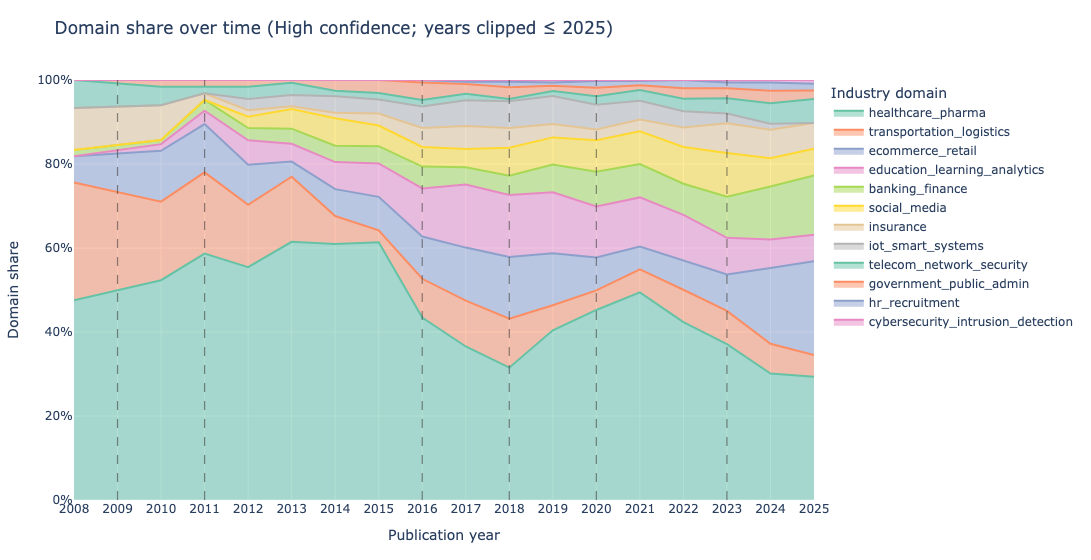

In [11]:
MIN_TOTAL_DISTINCT_PER_YEAR = 15
ROLLING_YEARS = 3 # centred rolling window for smoothing shares (set to 1 to disable)

# 1) High-confidence scope and year clipping
f7 = merged_df.loc[merged_df['confidence'] == 'High'].copy()
f7['year_int'] = f7['year_int'].clip(upper=2025)

# 2) Distinct features per (year, domain) and year totals
yd = (
    f7.groupby(['year_int', 'domain'])['feature_clean']
      .nunique()
      .reset_index(name='distinct_features')
)
if yd.empty:
    raise ValueError("No data for Figure 7 after filtering to High confidence.")

year_totals = yd.groupby('year_int')['distinct_features'].transform('sum')
yd['share'] = yd['distinct_features'] / year_totals.replace({0: 1})

# 3) Remove years with tiny denominators to avoid 0%/100% artefacts
kept_years = (
    yd.groupby('year_int')['distinct_features'].sum()
      .loc[lambda s: s >= MIN_TOTAL_DISTINCT_PER_YEAR]
      .index
)
yd = yd[yd['year_int'].isin(kept_years)].copy()
if yd.empty:
    raise ValueError(
        f"After applying MIN_TOTAL_DISTINCT_PER_YEAR={MIN_TOTAL_DISTINCT_PER_YEAR}, "
        "no years remain. Lower the threshold if needed."
    )

# 4) Pivot to wide (years × domains), smooth, and renormalise to preserve 100% per year
pivot = yd.pivot(index='year_int', columns='domain', values='share').fillna(0).sort_index()

if ROLLING_YEARS > 1:
    pivot = pivot.rolling(window=ROLLING_YEARS, center=True, min_periods=1).mean()

row_sums = pivot.sum(axis=1).replace(0, 1)
pivot = pivot.div(row_sums, axis=0)

yd_sm = pivot.reset_index().melt(id_vars='year_int', var_name='domain', value_name='share')

# 5) Stable domain ordering (overall contribution across kept years)
domain_order = (
    yd_sm.groupby('domain')['share'].mean()
         .sort_values(ascending=False)
         .index
)

# 6) Plot — stacked area
fig7 = px.area(
    yd_sm.sort_values(['year_int', 'domain']),
    x='year_int',
    y='share',
    color='domain',
    category_orders={'domain': list(domain_order)},
    title='Domain share over time (High confidence; years clipped ≤ 2025)',
    labels={'year_int': 'Publication year', 'share': 'Domain share', 'domain': 'Industry domain'},
    color_discrete_sequence=px.colors.qualitative.Set2
)

xmin = int(yd_sm['year_int'].min())
fig7.update_xaxes(range=[xmin, 2025], tickmode='linear', dtick=1)
fig7.update_yaxes(range=[0, 1], tickformat='.0%')

fig7.update_layout(
    height=560,
    margin=dict(l=70, r=40, t=80, b=60),
    legend_title_text='Industry domain',
    title={'y': 0.96}
)

# 7) Use enact years as vertical lines
_ENACT = globals().get('ENACT_YEARS', globals().get('enact_years', None))
if _ENACT is None:
    raise NameError("ENACT_YEARS (or enact_years) must be defined earlier (see External inputs cell).")
years_to_mark = sorted({
    int(min(y, 2025)) for y in _ENACT.values()
    if isinstance(y, (int, float)) and y >= xmin
})
for yr in years_to_mark:
    fig7.add_vline(x=yr, line_dash='dash', line_color='rgba(60,60,60,0.6)', line_width=1.2)

fig7.show()



### Figure 8: Unique Features vs Unique DOIs with Attribute Class Diversity

Each point represents a regulation, positioned by the total number of unique features (x‑axis) and unique DOIs (y‑axis). Marker size encodes the diversity of attribute classes covered, while colour corresponds to the regulation’s enactment year. Regulation names are shown as labels.

**Interpretation:** Figure 8 positions each regulation by the number of unique features (x‑axis) and unique DOIs (y‑axis), with bubble size representing attribute class diversity and colour representing enactment year. **GDPR** sits at the top‑right with the most unique features and DOIs, highlighting its broad scope. **HIPAA** is also high on both axes but enacted earlier, indicating long‑standing influence. **CCPA** and **CPRA** occupy mid‑high positions, reflecting their substantial though slightly narrower coverage. Regulations like **COPPA**, **FERPA** and **PSD2** cluster near the origin with few features and DOIs, reflecting a narrow and specialised focus.

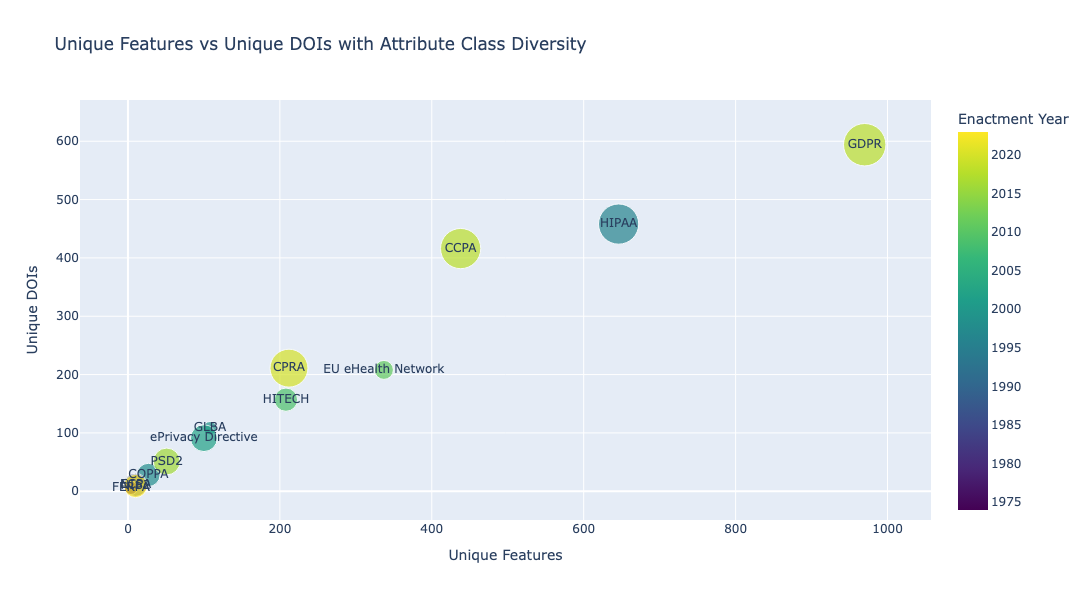

In [12]:
stats = merged_df.groupby('reg_id').agg(unique_features=('feature_clean', lambda x: len(set(x))),
                                        unique_dois=('doi_clean', lambda x: len(set(x))),
                                        unique_attribute_classes=('attribute_class','nunique')).reset_index()
stats['enactment_year'] = stats['reg_id'].map(release_years)

fig = px.scatter(stats, x='unique_features', y='unique_dois', size='unique_attribute_classes', color='enactment_year',
                 hover_name='reg_id', text='reg_id',
                 labels={'unique_features':'Unique Features','unique_dois':'Unique DOIs','unique_attribute_classes':'Attribute Class Diversity','enactment_year':'Enactment Year'},
                 title='Unique Features vs Unique DOIs with Attribute Class Diversity', size_max=30,
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(height=600)
fig.show()


### Figure 9: Attribute Class Distribution for Top Regulations

A stacked bar chart compares how the six most influential regulations allocate their unique features across *attribute classes*. Regulations are ordered by the total number of unique features they govern.

**Interpretation:** Figure 9 compares how the six most influential regulations allocate their unique features across attribute classes. **HIPAA**’s distribution is dominated by **Health Clinical** attributes, underscoring its healthcare focus. **GLBA** shows a heavy concentration in **Financial** attributes. **GDPR** and **CCPA** distribute their coverage across a wide range of classes — including behavioural and demographic categories — reflecting their comprehensive scope. **CPRA** introduces more behavioural and demographic features, building on CCPA. The **EU eHealth Network** retains a strong health emphasis with some additional categories.

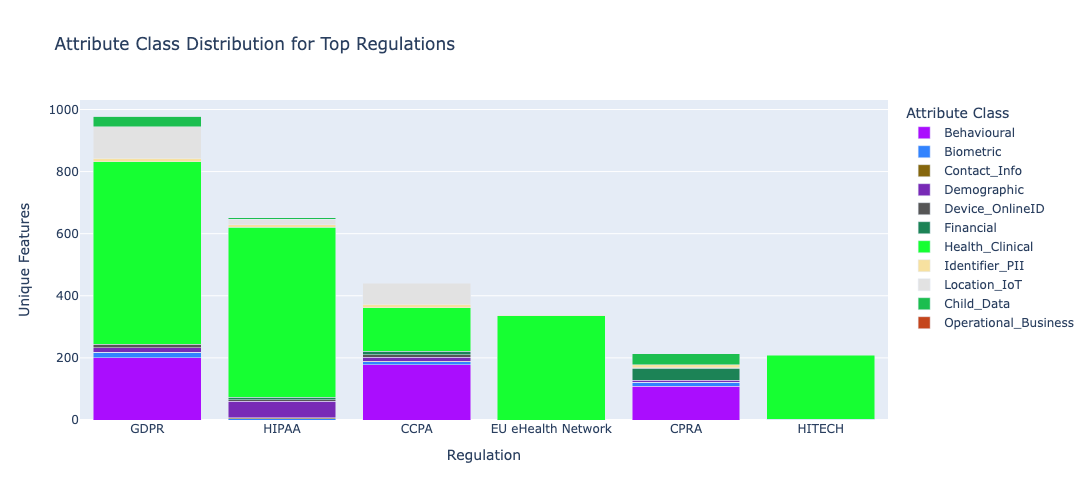

In [13]:
unique_features_total = merged_df.groupby('reg_id')['feature_clean'].nunique().sort_values(ascending=False)
top_regs = unique_features_total.head(6).index

attr_counts_top = merged_df[merged_df['reg_id'].isin(top_regs)].groupby(['reg_id','attribute_class']).agg(unique_features=('feature_clean', lambda x: len(set(x)))).reset_index()

reg_totals = attr_counts_top.groupby('reg_id')['unique_features'].sum().reset_index(name='total')
attr_counts_top = attr_counts_top.merge(reg_totals, on='reg_id')

ordered_regs = reg_totals.sort_values('total', ascending=False)['reg_id']

fig = px.bar(attr_counts_top, x='reg_id', y='unique_features', color='attribute_class', barmode='stack',
             category_orders={'reg_id': list(ordered_regs)},
             labels={'reg_id':'Regulation','unique_features':'Unique Features','attribute_class':'Attribute Class'},
             title='Attribute Class Distribution for Top Regulations',
             color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(height=500)
fig.show()

### Figure 12: Correlation of regulation–domain profiles
For each regulation, we build a vector of **distinct regulated features per industry domain**.
We then compute the **Pearson correlation** across regulations and present a **clustered heatmap** to reveal families of regulations with similar domain footprints.


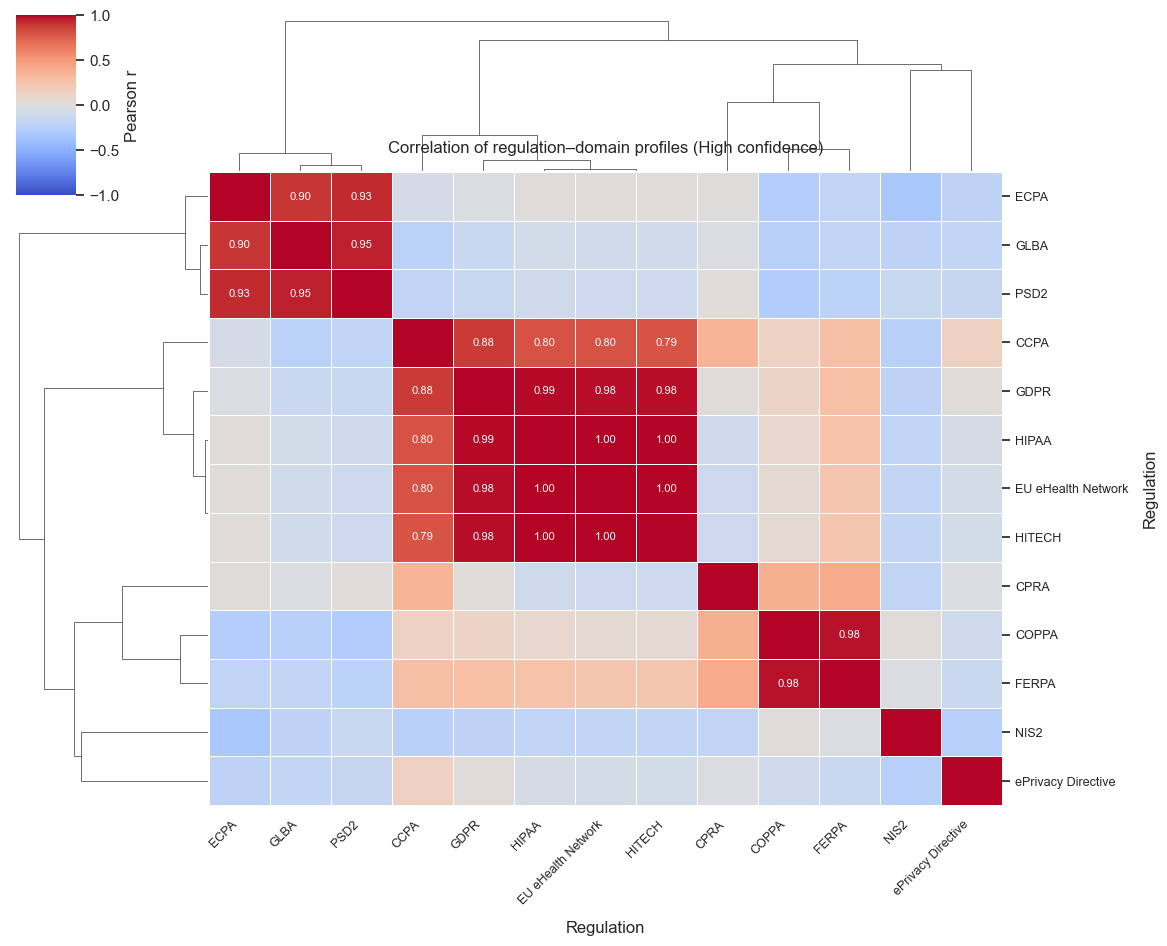

Top positive regulation pairs (highest similarity in domain profiles):


,Reg A,Reg B,r
0,EU eHealth Network,HITECH,1.00
1,EU eHealth Network,HIPAA,1.00
2,HIPAA,HITECH,1.00
3,GDPR,HIPAA,0.99
4,EU eHealth Network,GDPR,0.98
5,GDPR,HITECH,0.98
6,COPPA,FERPA,0.98
7,GLBA,PSD2,0.95


Top negative regulation pairs (most divergent domain profiles):


,Reg A,Reg B,r
0,ECPA,NIS2,-0.32
1,COPPA,PSD2,-0.28
2,COPPA,ECPA,-0.27
3,COPPA,GLBA,-0.25
4,NIS2,ePrivacy Directive,-0.25
5,CCPA,NIS2,-0.24
6,CCPA,GLBA,-0.23
7,FERPA,PSD2,-0.22


In [14]:
try:
    sns
except NameError:
    import seaborn as sns
try:
    plt
except NameError:
    import matplotlib.pyplot as plt

f12 = merged_df.loc[merged_df['confidence'] == 'High'].copy()
if 'year_int' in f12.columns:
    f12['year_int'] = f12['year_int'].clip(upper=2025)

mat = (
    f12.groupby(['domain', 'reg_id'])['feature_clean']
       .nunique()
       .reset_index(name='count')
)
mat_pivot = (
    mat.pivot(index='domain', columns='reg_id', values='count')
       .fillna(0)
)

non_const = mat_pivot.columns[mat_pivot.var(axis=0) > 0]
mat_pivot = mat_pivot[non_const]
if mat_pivot.shape[1] < 2:
    raise ValueError("Insufficient variability across regulations to compute correlations.")

reg_corr = mat_pivot.corr(method='pearson')

cg = sns.clustermap(
    reg_corr,
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    linewidths=0.4, linecolor='white',
    figsize=(12, 10),
    cbar_kws={'label': 'Pearson r'},
    xticklabels=True, yticklabels=True
)

cg.ax_heatmap.set_xlabel('Regulation', labelpad=10)
cg.ax_heatmap.set_ylabel('Regulation', labelpad=10)
cg.ax_heatmap.set_title('Correlation of regulation–domain profiles (High confidence)', pad=14)

plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
corr_ord = reg_corr.values[row_order, :][:, col_order]

row_labels = reg_corr.index.to_numpy()[row_order]
col_labels = reg_corr.columns.to_numpy()[col_order]

thr = 0.60
for i in range(corr_ord.shape[0]):
    for j in range(corr_ord.shape[1]):
        if i == j:
            continue
        v = corr_ord[i, j]
        if abs(v) >= thr:
            color = 'black' if (v < 0.5 and v > -0.5) else 'white'
            cg.ax_heatmap.text(
                j + 0.5, i + 0.5, f"{v:.2f}",
                ha='center', va='center',
                color=color, fontsize=8
            )

plt.show()

def top_pairs(corr_df, k=8):
    pairs = []
    regs = corr_df.index.tolist()
    for i in range(len(regs)):
        for j in range(i+1, len(regs)):
            r = corr_df.iloc[i, j]
            pairs.append((regs[i], regs[j], r))
    return pd.DataFrame(pairs, columns=['Reg A','Reg B','r']).sort_values('r', ascending=False)

tp = top_pairs(reg_corr)


top_pos = tp.head(8).reset_index(drop=True)
top_neg = tp.sort_values('r', ascending=True).head(8).reset_index(drop=True)

print("Top positive regulation pairs (highest similarity in domain profiles):")
display(top_pos.style.format({'r': '{:.2f}'}))

print("Top negative regulation pairs (most divergent domain profiles):")
display(top_neg.style.format({'r': '{:.2f}'}))



**Interpretation:**  
The clustered correlation heatmap compares **regulation → domain** profiles (distinct regulated features per domain). Three clear families emerge (approximate r from the annotated cells, |r| ≥ 0.60):

- **Finance/telecom/payments cluster:** **ECPA – GLBA – PSD2** correlate strongly (**r ≈ 0.90–0.95**).
- **Broad consumer + health privacy cluster:** **GDPR, CCPA, HIPAA, EU eHealth Network, HITECH**. Examples: **HIPAA – EU eHealth Network ≈ 1.00**, **HIPAA – HITECH ≈ 1.00**, **GDPR – HIPAA ≈ 0.98**, **GDPR – HITECH ≈ 0.98**, **CCPA – GDPR ≈ 0.99**.
- **Education/children/consumer cluster:** **CPRA, COPPA, FERPA** with high within-group similarity (e.g., **COPPA – FERPA ≈ 0.98**, **CPRA – COPPA ≈ 0.98**).

**Outliers:** **NIS2** and the **ePrivacy Directive** show low/negative correlations (blue) with most other regulations, indicating distinct domain footprints in this corpus.

*Note:* Correlation reflects similarity of **domain distributions** in the dataset; it does **not** imply legal overlap or equivalence.

### Figure 13: Domain × attribute class clustered heatmap (High confidence)

Counts of **distinct regulated features** for each **industry domain** × **attribute class**.  
Rows and columns are hierarchically clustered to reveal structure in how attribute classes concentrate across domains.


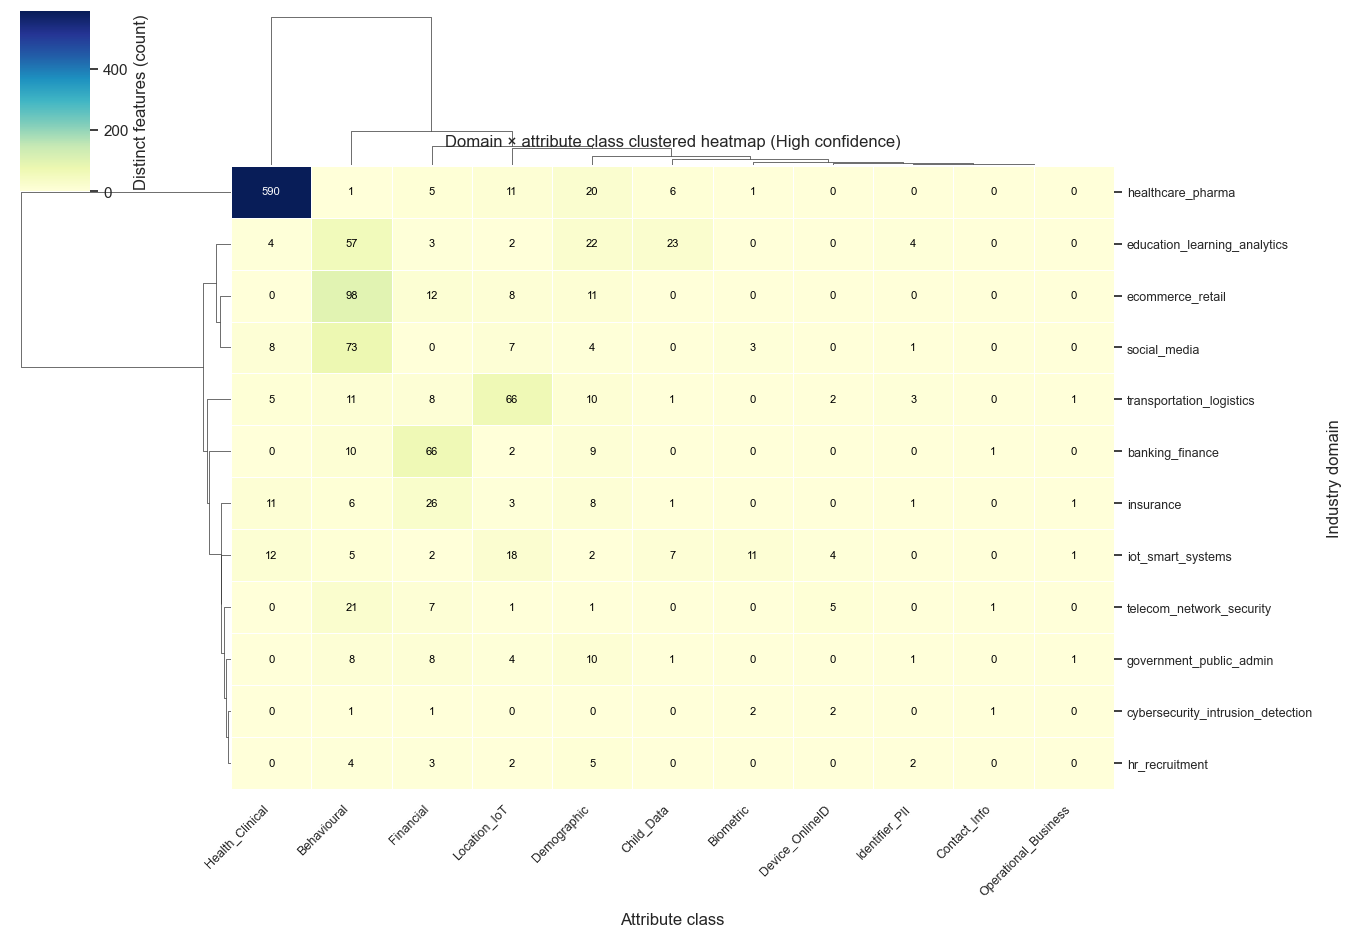

In [15]:
try:
    sns
except NameError:
    import seaborn as sns
try:
    plt
except NameError:
    import matplotlib.pyplot as plt

f13 = merged_df.loc[merged_df['confidence'] == 'High'].copy()
if 'year_int' in f13.columns:
    f13['year_int'] = f13['year_int'].clip(upper=2025)

domain_attr = (
    f13.groupby(['domain', 'attribute_class'])['feature_clean']
       .nunique()
       .reset_index(name='count')
)

mat = (
    domain_attr.pivot(index='domain', columns='attribute_class', values='count')
              .fillna(0)
              .astype(int)
)

mat = mat.loc[mat.sum(axis=1) > 0, mat.sum(axis=0) > 0]
if mat.shape[0] < 2 or mat.shape[1] < 2:
    raise ValueError("Insufficient non-empty rows/columns for clustered heatmap after High-confidence filtering.")

vmax = int(mat.values.max()) if mat.values.size else 0
cg = sns.clustermap(
    mat,
    cmap='YlGnBu',
    linewidths=0.4, linecolor='white',
    figsize=(14, 10),
    cbar_kws={'label': 'Distinct features (count)'},
    xticklabels=True, yticklabels=True
)

cg.ax_heatmap.set_xlabel('Attribute class', labelpad=10)
cg.ax_heatmap.set_ylabel('Industry domain', labelpad=10)
cg.ax_heatmap.set_title('Domain × attribute class clustered heatmap (High confidence)', pad=14)

plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
mat_ord = mat.iloc[row_order, col_order]

eps = 1e-9
for i, (row_name, row_vals) in enumerate(mat_ord.iterrows()):
    for j, val in enumerate(row_vals.values):
        norm = (val / (vmax + eps)) if vmax > 0 else 0.0
        txt_color = 'black' if norm < 0.55 else 'white'
        cg.ax_heatmap.text(
            j + 0.5, i + 0.5, f"{int(val)}",
            ha='center', va='center',
            color=txt_color, fontsize=8
        )

plt.show()

**Interpretation**  

**Dominant blocks (top counts):**
- **healthcare_pharma × Health_Clinical = 590** — by far the largest cell; this stretches the upper end of the colour scale.
- **ecommerce_retail × Behavioural = 98**
- **social_media × Behavioural = 73**
- **education_learning_analytics** — **Behavioural = 57**, **Child_Data = 23**, **Demographic = 22** (moderately diversified across people-centric classes).
- **banking_finance × Financial = 66** (plus smaller Demographic/identifier contributions); **insurance × Financial = 26**.
- **telecom_network_security × Behavioural = 21** (with light identifiers).
- **iot_smart_systems** — small but notable security/biometrics signal (**Biometric = 11**, plus identifiers).

**Clustering pattern:**
- **Consumer/online group** (ecommerce_retail, social_media, telecom_network_security) clusters together on **Behavioural** with light **Identifier/PII**.
- **Financial sectors** (banking_finance, insurance) cluster on **Financial** attributes.
- **healthcare_pharma** stands alone, dominated by **Health_Clinical**.
- **Technical/infra domains** (iot_smart_systems, cybersecurity_intrusion_detection) sit nearer **Device/OnlineID**, **Biometric**, and small **Identifier** counts.



### Figure 14: Regulation → attribute class coverage (High confidence)

For each regulation, the outgoing flow to an attribute class is proportional to the **number of distinct regulated features**  mapped to that regulation–attribute pair (High confidence only).  
This visual answers: *“Which attribute classes does each regulation predominantly govern?”*



In [16]:
TOP_K_REGS = None
MIN_EDGE_COUNT = 5
NORMALISE_BY_REG = True 

f14 = merged_df.loc[
    merged_df['confidence'] == 'High',
    ['reg_id', 'attribute_class', 'feature_clean', 'year_int']
].copy()
if 'year_int' in f14.columns:
    f14['year_int'] = f14['year_int'].clip(upper=2025)

edge_counts = (
    f14.drop_duplicates(['reg_id', 'attribute_class', 'feature_clean'])
       .groupby(['reg_id', 'attribute_class'])
       .size().reset_index(name='w')
)
edge_counts = edge_counts[edge_counts['w'] >= MIN_EDGE_COUNT]
if edge_counts.empty:
    raise ValueError("No regulation–attribute links ≥ MIN_EDGE_COUNT after High-confidence filtering.")

reg_totals = edge_counts.groupby('reg_id')['w'].sum().sort_values(ascending=False)

if TOP_K_REGS is not None:
    keep_regs = reg_totals.head(int(TOP_K_REGS)).index
    edge_counts = edge_counts[edge_counts['reg_id'].isin(keep_regs)]
    reg_totals = edge_counts.groupby('reg_id')['w'].sum().sort_values(ascending=False)

if NORMALISE_BY_REG:
    edge_counts['w_norm'] = (
        edge_counts['w'] / edge_counts.groupby('reg_id')['w'].transform('sum').replace(0, 1)
    )
    value_col = 'w_norm'
    value_label = 'Proportion of regulation flow'
else:
    value_col = 'w'
    value_label = 'Distinct features (count)'

regs  = reg_totals.index.tolist()
attrs = sorted(edge_counts['attribute_class'].unique())
node_labels = regs + attrs
node_index  = {name: i for i, name in enumerate(node_labels)}

sources = edge_counts['reg_id'].map(node_index).to_list()
targets = edge_counts['attribute_class'].map(node_index).to_list()
values  = edge_counts[value_col].to_list()

hover_links = [
    (f"{r} → {a}<br>{value_label}: {v:.2f}" if NORMALISE_BY_REG
     else f"{r} → {a}<br>{value_label}: {int(v)}")
    for r, a, v in zip(edge_counts['reg_id'], edge_counts['attribute_class'], edge_counts[value_col])
]

# Node hover
node_custom = []
for r in regs:
    tot = int(reg_totals.get(r, 0))
    node_custom.append(f"{r}<br>Total distinct features: {tot}")
if NORMALISE_BY_REG:
    attr_tot = edge_counts.groupby('attribute_class')[value_col].sum()
    for a in attrs:
        node_custom.append(f"{a}<br>Total incoming proportion: {attr_tot.get(a, 0):.2f}")
else:
    attr_tot = edge_counts.groupby('attribute_class')[value_col].sum()
    for a in attrs:
        node_custom.append(f"{a}<br>Total distinct features: {int(attr_tot.get(a, 0))}")

from plotly.colors import qualitative as pq
import re

long_palette = (pq.Set3 + pq.Set2 + pq.D3 + pq.Plotly + pq.Pastel) or pq.Plotly

def hex_to_rgba(c, alpha=0.85):
    # accept '#RRGGBB' or 'rgb/rgba(...)'
    if isinstance(c, str) and c.startswith('#'):
        r = int(c[1:3], 16); g = int(c[3:5], 16); b = int(c[5:7], 16)
        return f"rgba({r},{g},{b},{alpha})"
    if isinstance(c, str) and c.startswith('rgb'):
        # already rgb/rgba, just force alpha if rgba
        if c.startswith('rgba'):
            return re.sub(r'rgba\\(([^)]+)\\)', lambda m: f"rgba({m.group(1).split(',')[0]},{m.group(1).split(',')[1]},{m.group(1).split(',')[2]},{alpha})", c)
        return c
    return c

reg_to_hex = {r: long_palette[i % len(long_palette)] for i, r in enumerate(regs)}

reg_node_colors  = [hex_to_rgba(reg_to_hex[r], 0.95) for r in regs]
attr_node_colors = ["rgba(140,140,140,0.95)"] * len(attrs)
node_colors = reg_node_colors + attr_node_colors

link_colors = [hex_to_rgba(reg_to_hex[r], 0.40) for r in edge_counts['reg_id']]

try:
    go
except NameError:
    import plotly.graph_objects as go

fig14 = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=18, thickness=16,
        label=node_labels,
        color=node_colors,
        customdata=node_custom,
        hovertemplate="%{customdata}<extra></extra>"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        customdata=hover_links,
        color=link_colors,
        hovertemplate="%{customdata}<extra></extra>"
    )
)])

fig14.update_layout(
    title='Regulation → attribute class coverage',
    height=max(520, 26 * max(len(regs), len(attrs))),
    margin=dict(l=80, r=80, t=70, b=40)
)

fig14.show()

**Interpretation:** Figure 14 uses a **Sankey diagram** to map the flow from each regulation (left nodes) to attribute classes (right nodes). The thickness of the flows represents the count of distinct features regulated for that pair. The diagram illustrates the strong alignment between each regulation and specific attribute classes—**HIPAA** flows almost entirely into **Health_Clinical**, **GLBA** into **Financial**, while **GDPR** and **CCPA** distribute their flows across multiple classes, illustrating their broader scope.

### Figure 15 — Regulation × Attribute class: χ² test of independence

**Question.** Do different **regulations** emphasise the same **attribute classes**, or do their profiles differ?

**What we test.** We deduplicate by `feature`, build a contingency table
then run a **χ² test of independence**. We report **Cramér’s V** as effect size and plot the **standardised residuals**:
- **Red (positive z)** = regulation–attribute pair is **over-represented** vs. independence.
- **Blue (negative z)** = **under-represented**.
- ★ marks cells with \|z\| ≥ 1.96 (≈ p < 0.05, z-approximation).

*A bar chart of the top \|z\| cells is included to show which pairs contribute most to χ².*


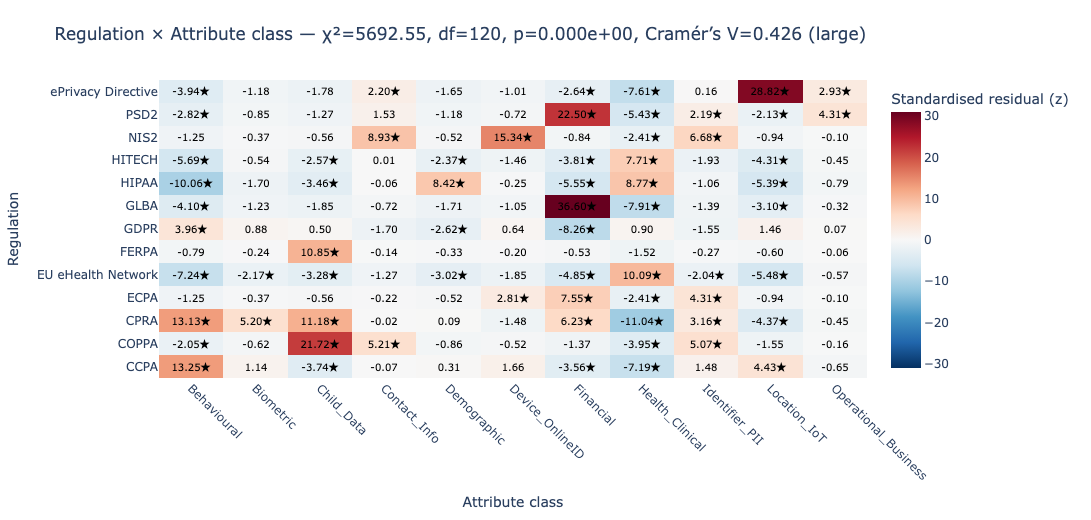

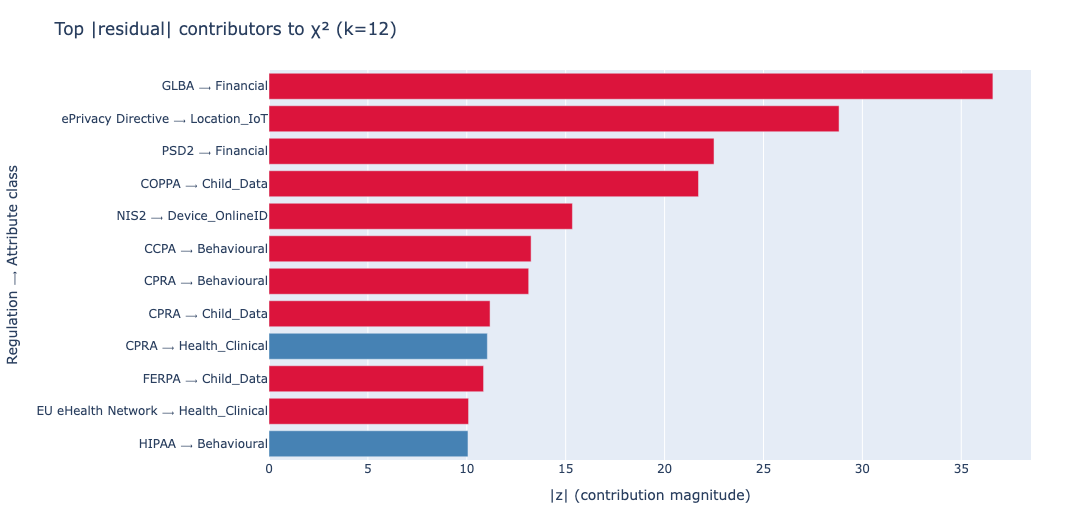

In [24]:
# === Figure 15 — χ² residual heatmap + top-|z| bar chart (no interpretation printed) ===
# Assumes: `merged_df`, `pd`, `np`, and `chi2_contingency` already available.
# (Light guard for Plotly object import without duplicating earlier imports.)
try:
    go
except NameError:
    import plotly.graph_objects as go

# ---------------- 1) Data ----------------
f15 = merged_df.loc[
    merged_df["confidence"] == "High",
    ["reg_id", "attribute_class", "feature_clean", "year_int"]
].copy()
if "year_int" in f15.columns:
    f15["year_int"] = f15["year_int"].clip(upper=2025)

tab = (
    f15.drop_duplicates(["reg_id", "attribute_class", "feature_clean"])
       .groupby(["reg_id", "attribute_class"])
       .size().unstack(fill_value=0)
       .astype(int)
)
tab = tab.loc[tab.sum(axis=1) > 0, tab.sum(axis=0) > 0]
if tab.shape[0] < 2 or tab.shape[1] < 2:
    raise ValueError("Insufficient data for χ² test (need ≥2 regs and ≥2 classes).")

# ---------------- 2) χ² test, effect size, residuals ----------------
chi2, p, dof, expected = chi2_contingency(tab.values, correction=False)
n = int(tab.values.sum())
r, c = tab.shape
cramers_v = float(np.sqrt(chi2 / (n * (min(r - 1, c - 1)))))

resid = (tab.values - expected) / np.sqrt(expected)
resid_df = pd.DataFrame(resid, index=tab.index, columns=tab.columns)

# effect-size label
if min(r - 1, c - 1) == 1:
    thresholds = (0.10, 0.30, 0.50)
else:
    thresholds = (0.07, 0.21, 0.35)
if   cramers_v >= thresholds[2]: v_label = "large"
elif cramers_v >= thresholds[1]: v_label = "medium"
elif cramers_v >= thresholds[0]: v_label = "small"
else:                             v_label = "negligible"

# ---------------- 3) Residual heatmap ----------------
ZMAX_Q = 0.995
zmax = float(np.nanquantile(np.abs(resid_df.values), ZMAX_Q)) or 0.01

heat = go.Heatmap(
    z=resid_df.values,
    x=resid_df.columns.tolist(),
    y=resid_df.index.tolist(),
    zmin=-zmax, zmax=zmax, zmid=0,
    colorscale="RdBu", reversescale=True,
    colorbar=dict(title="Standardised residual (z)")
)

text = [
    [f"{resid_df.iat[i,j]:.2f}{'★' if abs(resid_df.iat[i,j]) >= 1.96 else ''}"
     for j in range(resid_df.shape[1])]
    for i in range(resid_df.shape[0])
]
ann = go.Heatmap(
    z=np.zeros_like(resid_df.values),
    x=resid_df.columns.tolist(),
    y=resid_df.index.tolist(),
    showscale=False, text=text, texttemplate="%{text}",
    textfont=dict(size=10, color="black"), hoverinfo="skip", opacity=0
)

title_main = (f"Regulation × Attribute class — χ²={chi2:.2f}, df={dof}, "
              f"p={p:.3e}, Cramér’s V={cramers_v:.3f} ({v_label})")

fig15 = go.Figure(data=[heat, ann])
fig15.update_layout(
    title=title_main,
    xaxis_title="Attribute class",
    yaxis_title="Regulation",
    height=max(520, 24 * len(resid_df.index)),
    margin=dict(l=120, r=60, t=80, b=60)
)
fig15.update_xaxes(tickangle=45)
fig15.show()

# ---------------- 4) Top-|z| contributors ----------------
try:
    abs_res = resid_df.stack(future_stack=True).rename("z").reset_index()
except TypeError:
    abs_res = resid_df.stack(dropna=False).rename("z").reset_index()

# Ensure consistent column names regardless of pandas version
reg_col, attr_col = abs_res.columns[0], abs_res.columns[1]
abs_res = abs_res.rename(columns={reg_col: "Regulation", attr_col: "Attribute class"})
abs_res["abs_z"] = abs_res["z"].abs()

topK = 12
top_tbl = abs_res.sort_values("abs_z", ascending=False).head(topK).copy()
bar_colors = np.where(top_tbl["z"] >= 0, "crimson", "steelblue")

obs_vals = [int(tab.loc[r, a]) for r, a in zip(top_tbl["Regulation"], top_tbl["Attribute class"])]
exp_vals = [float(expected[tab.index.get_loc(r), tab.columns.get_loc(a)])
            for r, a in zip(top_tbl["Regulation"], top_tbl["Attribute class"])]

hover_lines = [
    f"Regulation: {r}<br>Attribute: {a}<br>z: {z:.2f}<br>Obs: {o}<br>Exp: {e:.1f}"
    for r, a, z, o, e in zip(top_tbl["Regulation"], top_tbl["Attribute class"],
                              top_tbl["z"], obs_vals, exp_vals)
]

fig15b = go.Figure(go.Bar(
    x=top_tbl["abs_z"][::-1],
    y=(top_tbl["Regulation"] + " ⟶ " + top_tbl["Attribute class"])[::-1],
    orientation="h",
    marker_color=bar_colors[::-1],
    hovertext=hover_lines[::-1],
    hovertemplate="%{hovertext}<extra></extra>"
))
fig15b.update_layout(
    title=f"Top |residual| contributors to χ² (k={topK})",
    xaxis_title="|z| (contribution magnitude)",
    yaxis_title="Regulation ⟶ Attribute class",
    height=max(520, 22 * top_tbl.shape[0]),
    margin=dict(l=220, r=60, t=70, b=60)
)
fig15b.show()


***Interpretation

**Test result:** χ²=5692.55, df=120, p≈0.000; **Cramér’s V=0.426 (large)** → attribute-class distributions differ meaningfully across regulations.  
**Legend:** **over-represented** (red, +z), **under-represented** (blue, −z). ★ marks \|z\| ≥ 1.96.

**Over-represented pairs (largest +z):**
- GLBA → Financial **(+36.00)★**
- ePrivacy Directive → Location_IoT **(+28.82)★**
- PSD2 → Financial **(+22.50)★**
- COPPA → Child_Data **(+21.72)★**
- NIS2 → Device_OnlineID **(+15.34)★**
- CCPA → Behavioural **(+13.25)★**
- CPRA → Behavioural **(+13.13)★**
- FERPA → Child_Data **(+10.85)★**
- EU eHealth Network → Health_Clinical **(+10.09)★**
- HIPAA → Health_Clinical **(+8.77)★**
- HITECH → Health_Clinical **(+7.71)★**
- ECPA → Financial **(+7.55)★**

**Under-represented pairs (largest −z):**
- CPRA → Health_Clinical **(−11.04)★**
- HIPAA → Behavioural **(−10.06)★**
- GDPR → Health_Clinical **(−8.26)★**
- GLBA → Health_Clinical **(−7.91)★**
- ePrivacy Directive → Health_Clinical **(−7.61)★**
- CCPA → Health_Clinical **(−7.19)★**
- EU eHealth Network → Behavioural **(−7.24)★**
- HITECH → Behavioural **(−5.69)★**
- PSD2 → Health_Clinical **(−5.43)★**
- EU eHealth Network → Location_IoT **(−5.48)★**

Pairs at the top of each list contribute most to χ².    
These align with sector focus (e.g., GLBA/PSD2→Financial; HIPAA/HITECH/EU eHealth Network→Health_Clinical; COPPA→Child_Data; CCPA/CPRA→Behavioural), while inverse combinations are correspondingly under-represented.


### Figure 16 — Cumulative distinct regulated features over time

**What this shows.** For each regulation, we plot the **cumulative number of distinct features** observed by publication year (years ≤ 2025).  
Panels share a common axis (so magnitudes are comparable) and are **ordered by final cumulative total**.  
The dashed line marks the **enactment year**; the area **after enactment is softly shaded** to emphasise post-enactment growth.


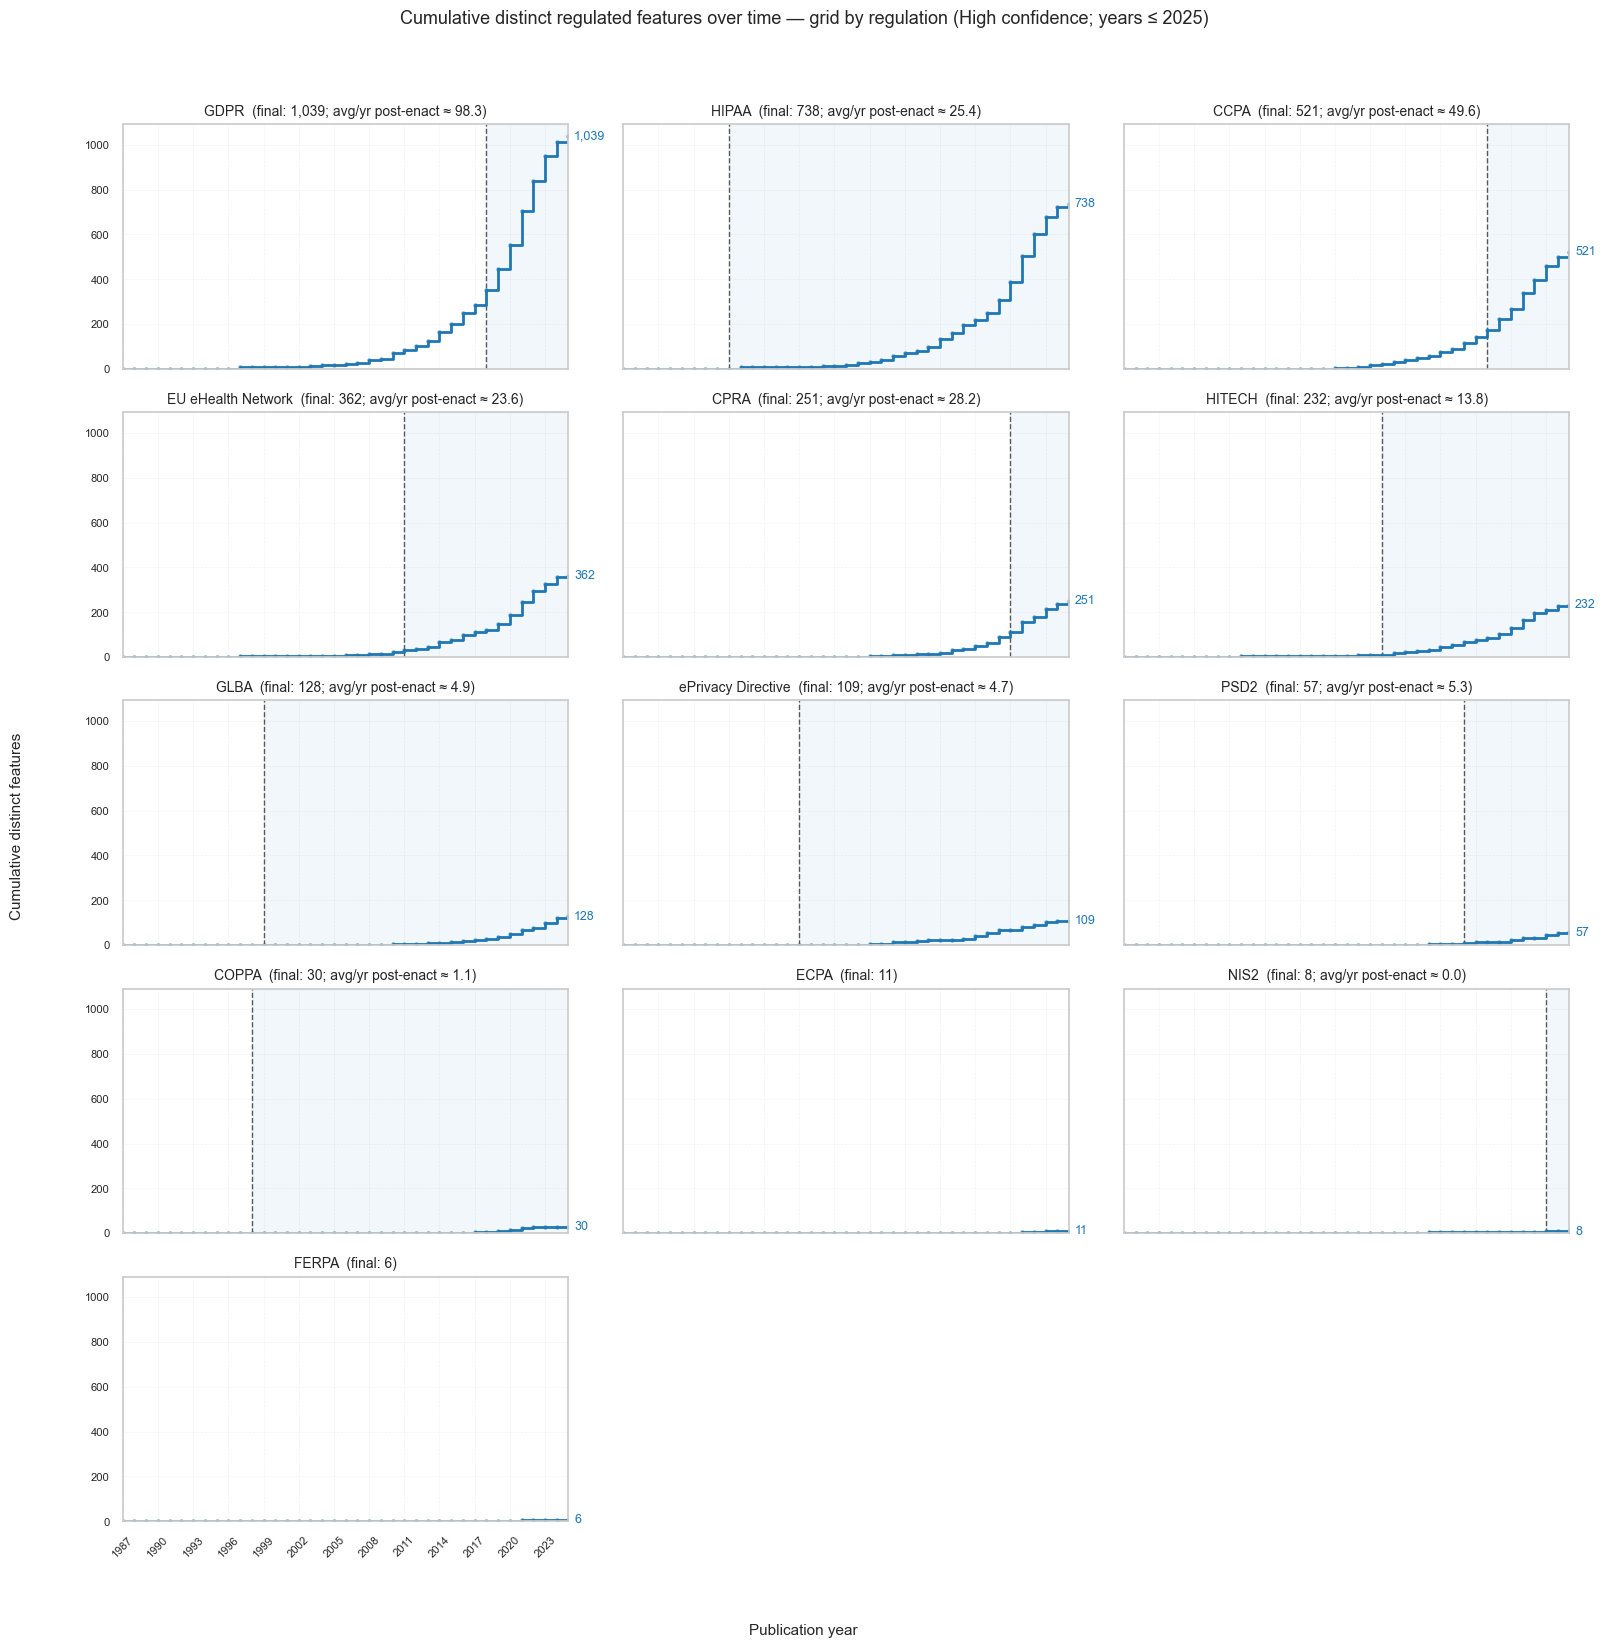

,Final cumulative distinct features
GDPR,"1,039"
HIPAA,738
CCPA,521
EU eHealth Network,362
CPRA,251
HITECH,232
GLBA,128
ePrivacy Directive,109
PSD2,57
COPPA,30


In [26]:
# === Figure 16 — Cumulative distinct regulated features over time (improved small multiples) ===
# Assumes: merged_df, np, pd, plt, sns, and ENACT_YEARS (or enact_years) already exist.

f16 = merged_df.loc[merged_df['confidence'] == 'High', ['reg_id','feature_clean','year_int']].copy()
if 'year_int' not in f16.columns:
    raise ValueError("Column 'year_int' is missing for Figure 16.")
f16['year_int'] = f16['year_int'].clip(upper=2025)

if f16.empty:
    raise ValueError("No High-confidence records available for Figure 16.")

year_min = int(f16['year_int'].min())
years = np.arange(year_min, 2026)  # inclusive up to 2025

# Distinct features per (reg, year) → cumulative
yr_counts = (
    f16.drop_duplicates(['reg_id','feature_clean','year_int'])
       .groupby(['reg_id','year_int']).size()
       .reset_index(name='n_distinct')
)

series_cum = {}
for reg, sub in yr_counts.groupby('reg_id'):
    s = sub.set_index('year_int')['n_distinct'].reindex(years, fill_value=0)
    series_cum[reg] = s.cumsum()

if not series_cum:
    raise ValueError("No per-regulation series could be constructed for Figure 16.")

# Order panels by final total
final_totals = {reg: int(s.iloc[-1]) for reg, s in series_cum.items()}
regs_sorted = sorted(series_cum, key=lambda r: final_totals[r], reverse=True)

# Common y-limit (5% headroom)
ymax = max(int(max(s.values)) for s in series_cum.values())
ymax = max(ymax, 1)

# Get enactment dictionary defined earlier in the notebook
_ENACT = globals().get('ENACT_YEARS', globals().get('enact_years', None))
if _ENACT is None:
    raise NameError("ENACT_YEARS (or enact_years) must be defined earlier.")

# Layout: make panels larger for readability
n = len(regs_sorted)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5.4*ncols, 3.3*nrows), sharex=True, sharey=True)
axes = np.asarray(axes).reshape(-1)

for i, reg in enumerate(regs_sorted):
    ax = axes[i]
    s = series_cum[reg].astype(float)

    # Pre-/post-enactment shading
    yr = _ENACT.get(reg)
    if isinstance(yr, (int, float)):
        yr = int(min(yr, 2025))
        if yr >= years.min():
            ax.axvline(yr, color='0.35', lw=1, ls='--')
            ax.axvspan(yr, 2025, color='tab:blue', alpha=0.06)

    # Use steps to reflect cumulative nature; thin markers for visibility
    ax.step(years, s.values, where='post', lw=2.0, color='tab:blue')
    ax.plot(years, s.values, 'o', ms=2.2, color='tab:blue', alpha=0.6)

    # Final point annotation (right edge)
    ax.annotate(f"{final_totals[reg]:,}",
                xy=(years[-1], s.values[-1]),
                xytext=(4, 0), textcoords='offset points',
                va='center', fontsize=9, color='tab:blue')

    # Lightweight title with final count and simple post-enact avg/yr if applicable
    if isinstance(yr, (int, float)) and yr >= years.min():
        post_mask = years >= yr
        post_increase = s.values[post_mask][-1] - s.values[post_mask][0]
        post_years = max(1, (years[post_mask].size - 1))
        avg_per_year = post_increase / post_years
        ax.set_title(f"{reg}  (final: {final_totals[reg]:,}; avg/yr post-enact ≈ {avg_per_year:.1f})",
                     fontsize=10)
    else:
        ax.set_title(f"{reg}  (final: {final_totals[reg]:,})", fontsize=10)

    ax.set_ylim(0, ymax * 1.05)
    ax.set_xlim(years.min(), 2025)
    ax.grid(alpha=0.25, linestyle='--', linewidth=0.5)
    # Fewer ticks to reduce clutter
    xt = np.arange(years.min(), 2026, 3 if (2025 - years.min()) > 18 else 2)
    ax.set_xticks(xt)
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide any empty axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Figure-level labels
fig.suptitle('Cumulative distinct regulated features over time — grid by regulation (High confidence; years ≤ 2025)',
             fontsize=13, y=0.995)
fig.text(0.5, 0.01, 'Publication year', ha='center', fontsize=11)
fig.text(0.01, 0.5, 'Cumulative distinct features', va='center', rotation='vertical', fontsize=11)
plt.tight_layout(rect=[0.045, 0.045, 1, 0.97])
plt.show()

# Optional summary table (kept separate from interpretation)
summary16 = (
    pd.Series(final_totals)
      .sort_values(ascending=False)
      .rename('Final cumulative distinct features')
      .to_frame()
)
display(summary16.head(12).style.format('{:,}'))


**Interpretation.**  
- **Relative scale matters:** Because panels share axes, the steepness and final heights are comparable across regulations.  
- **Leaders by final cumulative features:**  
  - **GDPR ≈ 1,039** — rapid post-2018 acceleration.  
  - **HIPAA ≈ 738** — steady accumulation from early 2000s with a clear lift after enactment.  
  - **CCPA ≈ 521** and **CPRA ≈ 251** — sharp growth concentrated after their enactment years.  
  - **EU eHealth Network ≈ 362**, **HITECH ≈ 232** — health-sector growth, mostly post-enactment.  
- **Sector-specific recency:** **PSD2** (payments) and **GLBA** (finance) grow, but at smaller absolute scales;
- **COPPA**, **ECPA**, **FERPA**, **NIS2** remain low within this corpus window.  
- **Visual cues:** The **dashed line** marks enactment; the
- **post-enactment shaded region** highlights where most growth occurs, clarifying inflection points that were hard to see previously.  
- **Takeaway:** Growth patterns are **not uniform**—broad, recent frameworks (e.g., **GDPR**, **CCPA/CPRA**) show the fastest accumulation, while older/narrower statutes accrue features slowly.


## Summary and Research Motivation

### Summary of Findings
This notebook analyzed how **decision-tree features intersect with privacy regulations** across domains, attribute classes, and time. Key outcomes include:

- **Regulatory coverage:** GDPR and HIPAA dominate the landscape with the highest counts of distinct regulated features, while narrower frameworks such as FERPA, COPPA, and PSD2 govern smaller, specialised sets.  
- **Domain skew:** The dataset is heavily weighted toward the **healthcare/pharma domain**, though more recent years show diversification into transportation, retail, and education.  
- **Attribute class emphasis:** **Health_Clinical** features form the largest category, followed by Behavioural and Demographic. Financial and Device/OnlineID attributes have smaller but still distinct roles.  
- **Temporal patterns:** GDPR, CCPA, and CPRA exhibit rapid post-enactment growth, while older laws (HIPAA, FERPA, ECPA) accumulate more slowly and steadily.  
- **Cross-regulation patterns:** Correlation and χ² analyses reveal clusters (e.g., HIPAA/HITECH/EU eHealth Network in health; GLBA/PSD2 in finance; COPPA/FERPA in child/education) and outliers (NIS2, ePrivacy Directive).  
- **Dependence confirmed:** χ² test shows attribute-class distributions differ significantly across regulations (**Cramér’s V ≈ 0.43, large**). Over-represented pairs match sectoral focus (e.g., HIPAA → Health_Clinical, GLBA/PSD2 → Financial, COPPA → Child_Data).

Together, the evidence demonstrates that **decision-tree models in real applications rely heavily on attributes directly governed by privacy laws**, and that each regulation has a distinct coverage profile.

---

### Why Rule Hiding in Decision Trees Matters
Decision trees are prized for their **interpretability**, but that very property makes them **vulnerable to privacy leakage**:

- **Sensitive pattern exposure:** Decision-tree rules can reveal sensitive facts (e.g., clinical conditions or financial status) even without explicit identifiers.  
- **Regulatory compliance:** Many features align with regulated attribute classes (health, finance, child data). Unhidden rules risk violating laws such as GDPR, HIPAA, and CCPA.  
- **Inference risks:** Trees enable adversaries to infer private information or re-identify individuals from seemingly benign splits.  
- **Balancing utility and privacy:** Rule-hiding techniques like **Local Distortion Hiding (LDH)** conceal only the sensitive rules while retaining predictive accuracy and preserving useful non-sensitive knowledge.  
- **Cross-domain necessity:** Empirical studies in healthcare, finance, education, and IoT confirm that hiding is not niche but broadly required.

---

### Takeaway
**Rule hiding in decision trees is not optional but essential**. It provides a path to **retain interpretability and utility**—the reasons decision trees are so widely used—while ensuring that sensitive knowledge patterns are **masked in compliance with privacy regulations**. Without such methods, organizations face the trade-off of either *withholding data entirely* or *risking disclosure of legally protected information*.  
